In [ ]:
import pandas as pd

df = pd.read_csv("IMDB-Dataset.csv")

print("Shape:", df.shape)
print("\nColumn names:", df.columns.tolist())

df.head()


Shape: (50000, 2)

Column names: ['review', 'sentiment']


,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [ ]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   review     50000 non-null  object
 1   sentiment  50000 non-null  object
dtypes: object(2)
memory usage: 781.4+ KB


In [ ]:
df.isnull().sum()


,0
review,0
sentiment,0


In [ ]:
df.duplicated().sum()


np.int64(418)

In [ ]:
df['sentiment'].value_counts()


,count
sentiment,
positive,25000
negative,25000


In [ ]:
before = len(df)
df = df.drop_duplicates()
after = len(df)

print(f"Removed {before - after} duplicate rows.")
print("New shape:", df.shape)


Removed 418 duplicate rows.
New shape: (49582, 2)


In [ ]:
df['label'] = df['sentiment'].map({'positive': 1, 'negative': 0})
df[['sentiment', 'label']].head()


,sentiment,label
0,positive,1
1,positive,1
2,positive,1
3,negative,0
4,positive,1


In [ ]:
import re
from bs4 import BeautifulSoup

def clean_review(text):
    # remove HTML tags
    text = BeautifulSoup(text, "html.parser").get_text()
    # lowercase
    text = text.lower()
    # remove URLs
    text = re.sub(r"http\S+|www\S+", " ", text)
    # remove non-alphanumeric characters
    text = re.sub(r"[^a-z0-9\s]", " ", text)
    # collapse multiple spaces
    text = re.sub(r"\s+", " ", text).strip()
    return text

df['clean_review'] = df['review'].apply(clean_review)

df[['review', 'clean_review']].head(3)


,review,clean_review
0,One of the other reviewers has mentioned that ...,one of the other reviewers has mentioned that ...
1,A wonderful little production. <br /><br />The...,a wonderful little production the filming tech...
2,I thought this was a wonderful way to spend ti...,i thought this was a wonderful way to spend ti...


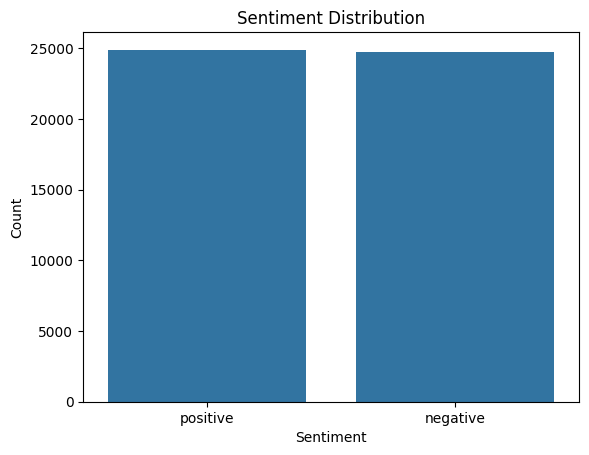

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(x=df['sentiment'])
plt.title("Sentiment Distribution")
plt.xlabel("Sentiment")
plt.ylabel("Count")
plt.show()


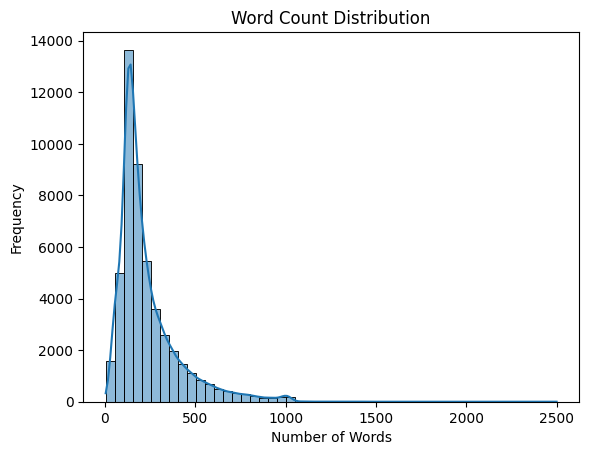

In [ ]:
df['word_count'] = df['clean_review'].apply(lambda x: len(x.split()))
sns.histplot(df['word_count'], kde=True, bins=50)
plt.title("Word Count Distribution")
plt.xlabel("Number of Words")
plt.ylabel("Frequency")
plt.show()


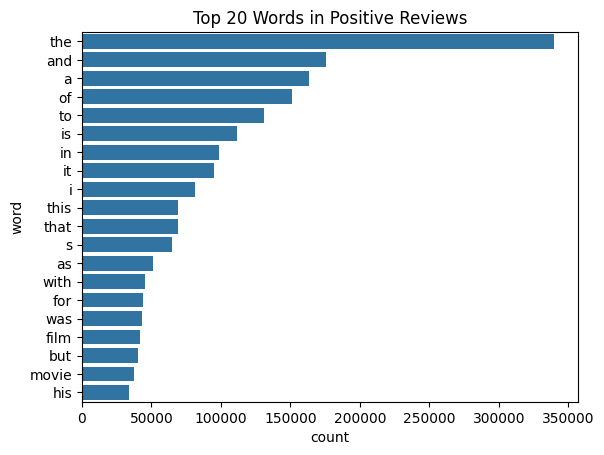

In [ ]:
from collections import Counter

positive_words = Counter(" ".join(df[df['label']==1]['clean_review']).split()).most_common(20)

pos_df = pd.DataFrame(positive_words, columns=['word', 'count'])

sns.barplot(data=pos_df, x='count', y='word')
plt.title("Top 20 Words in Positive Reviews")
plt.show()


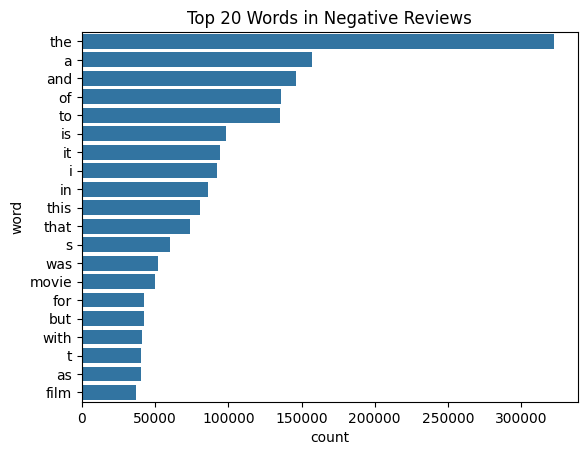

In [ ]:
negative_words = Counter(" ".join(df[df['label']==0]['clean_review']).split()).most_common(20)

neg_df = pd.DataFrame(negative_words, columns=['word', 'count'])

sns.barplot(data=neg_df, x='count', y='word')
plt.title("Top 20 Words in Negative Reviews")
plt.show()


In [ ]:
X = df['clean_review']
y = df['label']


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)


In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(
    max_features=50000,      # keep top 50,000 words
    ngram_range=(1, 2),      # use unigrams + bigrams
    stop_words='english'     # remove common English stopwords
)


In [ ]:
tfidf.fit(X_train)


TfidfVectorizer(max_features=50000, ngram_range=(1, 2), stop_words='english')

In [ ]:
X_train_tfidf = tfidf.transform(X_train)
X_test_tfidf = tfidf.transform(X_test)


In [ ]:
X_train_tfidf.shape
X_test_tfidf.shape


(9917, 50000)

In [ ]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(
    max_iter=2000,
    C=1.0,
    n_jobs=-1
)
model.fit(X_train_tfidf, y_train)


LogisticRegression(max_iter=2000, n_jobs=-1)

Accuracy: 0.8978521730362005
ROC AUC: 0.9638253374429258

Classification report:
               precision    recall  f1-score   support

           0     0.9090    0.8834    0.8960      4940
           1     0.8874    0.9122    0.8996      4977

    accuracy                         0.8979      9917
   macro avg     0.8982    0.8978    0.8978      9917
weighted avg     0.8982    0.8979    0.8978      9917



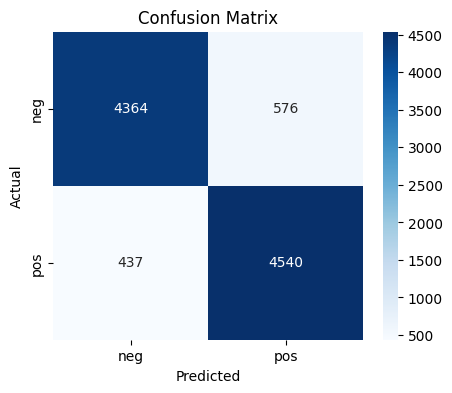

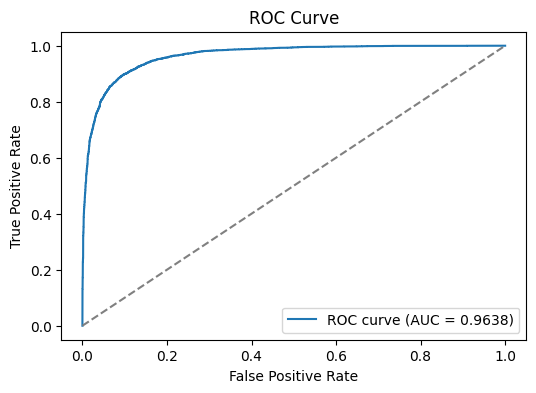

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Predictions & probabilities
y_pred = model.predict(X_test_tfidf)
# if your pipeline or model supports predict_proba use that; otherwise use decision_function
if hasattr(model, "predict_proba"):
    y_proba = model.predict_proba(X_test_tfidf)[:,1]
else:
    # convert decision_function to probability-like scores for ROC
    y_scores = model.decision_function(X_test_tfidf)
    # scale to 0-1 for plotting only (not true probabilities)
    y_proba = (y_scores - y_scores.min()) / (y_scores.max() - y_scores.min())

# 4. ROC AUC and ROC curve
roc_auc = roc_auc_score(y_test, y_proba)
fpr, tpr, _ = roc_curve(y_test, y_proba)

# 2. Metrics
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)
print("ROC AUC:", roc_auc)
print("\nClassification report:\n", classification_report(y_test, y_pred, digits=4))

# 3. Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['neg','pos'], yticklabels=['neg','pos'])
plt.xlabel("Predicted"); plt.ylabel("Actual"); plt.title("Confusion Matrix")
plt.show()

plt.figure(figsize=(6,4))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0,1],[0,1], linestyle='--', color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate"); plt.title("ROC Curve")
plt.legend(loc='lower right')
plt.show()


In [ ]:
import numpy as np
# feature names from TF-IDF
feature_names = tfidf.get_feature_names_out()

# coefficients: shape (n_classes,) for binary with scikit-learn (coef_ is [1 x n_features])
coefs = model.coef_[0]  # for binary: positive class weight

# top positive words (highest positive coef)
top_pos_idx = np.argsort(coefs)[-30:][::-1]   # top 30
top_neg_idx = np.argsort(coefs)[:30]          # top 30 negative

print("================\nTop positive words:\n=================")
for idx in top_pos_idx[:20]:
    print(f"{feature_names[idx]} \t {coefs[idx]:.4f}")

print("================\nTop negative words:\n================")
for idx in top_neg_idx[:20]:
    print(f"{feature_names[idx]} \t {coefs[idx]:.4f}")


Top positive words:
great 	 8.0689
excellent 	 8.0672
best 	 6.4840
perfect 	 6.0857
amazing 	 5.9178
wonderful 	 5.8474
favorite 	 5.1567
loved 	 5.1394
brilliant 	 5.1072
fun 	 4.9665
enjoyed 	 4.6608
today 	 4.4703
hilarious 	 4.4621
superb 	 4.2828
definitely 	 4.1011
love 	 4.0963
fantastic 	 4.0727
enjoyable 	 4.0270
especially 	 3.9717
highly 	 3.9323
Top negative words:
worst 	 -11.5375
awful 	 -8.9877
boring 	 -8.1636
bad 	 -8.0839
waste 	 -7.5634
poor 	 -7.2119
terrible 	 -6.9207
worse 	 -5.8743
horrible 	 -5.7051
dull 	 -5.5504
poorly 	 -5.2289
instead 	 -5.0408
stupid 	 -4.9582
supposed 	 -4.9443
annoying 	 -4.8615
fails 	 -4.8555
lame 	 -4.7221
minutes 	 -4.5904
unfortunately 	 -4.5433
script 	 -4.4801


In [ ]:
import joblib
from sklearn.pipeline import Pipeline

pipe = Pipeline([
    ("tfidf", tfidf),
    ("clf", model)
])

joblib.dump(pipe, "tfidf_logreg_pipeline.joblib")
print("Saved pipeline to tfidf_logreg_pipeline.joblib")


Saved pipeline to tfidf_logreg_pipeline.joblib


Using existing LogisticRegression model object 'model'.

Training LinearSVC...
Training MultinomialNB...

Evaluating: LogisticRegression
 Accuracy: 0.8979 | Precision: 0.8874 | Recall: 0.9122 | F1: 0.8996 | ROC AUC: 0.9638

 Classification Report:
               precision    recall  f1-score   support

           0     0.9090    0.8834    0.8960      4940
           1     0.8874    0.9122    0.8996      4977

    accuracy                         0.8979      9917
   macro avg     0.8982    0.8978    0.8978      9917
weighted avg     0.8982    0.8979    0.8978      9917


Evaluating: LinearSVC
 Accuracy: 0.9000 | Precision: 0.8957 | Recall: 0.9062 | F1: 0.9009 | ROC AUC: 0.9641

 Classification Report:
               precision    recall  f1-score   support

           0     0.9043    0.8937    0.8990      4940
           1     0.8957    0.9062    0.9009      4977

    accuracy                         0.9000      9917
   macro avg     0.9000    0.8999    0.9000      9917
weighted avg     

,accuracy,precision,recall,f1_score,roc_auc
model,,,,,
LinearSVC,0.899970,0.895730,0.906168,0.900919,0.964061
LogisticRegression,0.897852,0.887412,0.912196,0.899633,0.963825
MultinomialNB,0.878391,0.875075,0.883866,0.879448,0.947521



Saved summary to 'model_comparison_results.csv'


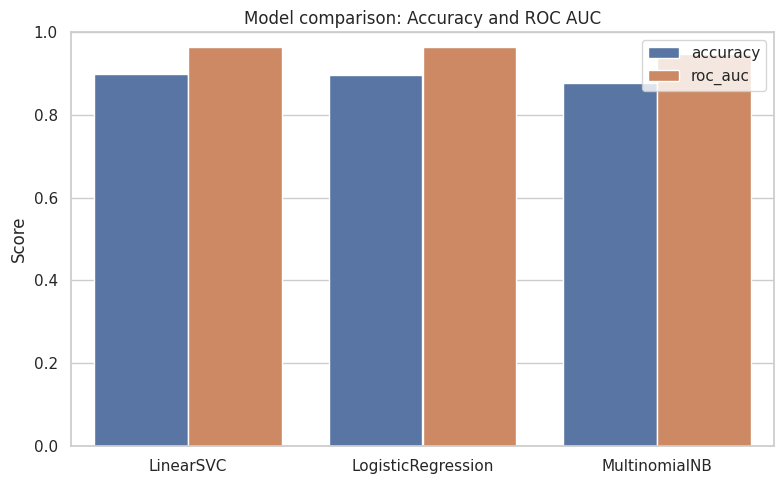

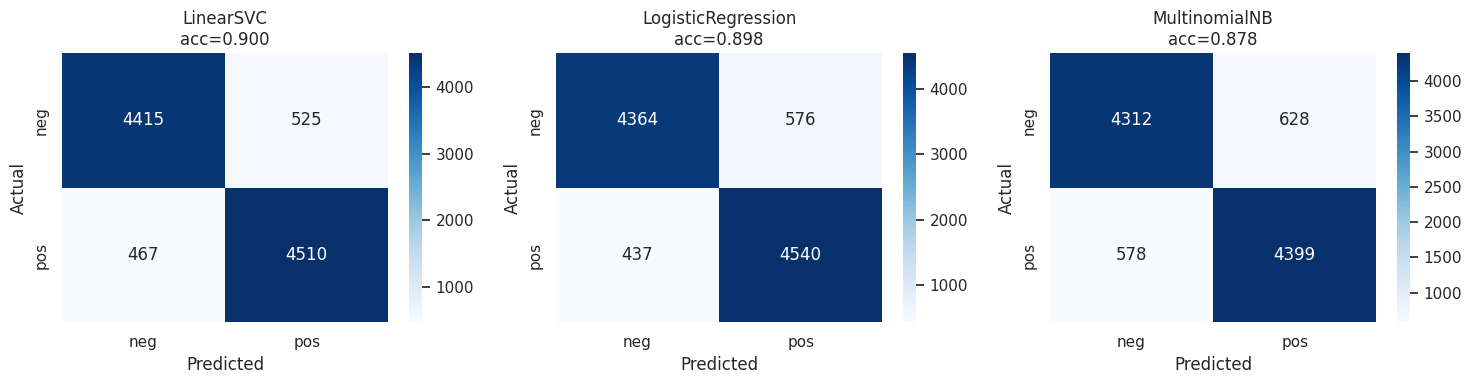


Done — comparison table saved and plots displayed. Use 'model_comparison_results.csv' for submission.


In [ ]:
# === Combined comparison of 3 models (run at the end of Notebook A) ===
# Assumes these variables exist in the notebook:
# tfidf, X_train_tfidf, X_test_tfidf, y_train, y_test, and 'model' (LogisticRegression) from Notebook A.
# If 'model' doesn't exist, this will train it here.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

sns.set(style="whitegrid")

# ---- Sanity checks ----
missing = []
for var in ['X_train_tfidf','X_test_tfidf','y_train','y_test','tfidf']:
    if var not in globals():
        missing.append(var)
if missing:
    raise RuntimeError(f"Missing variables in notebook: {missing}. Run the TF-IDF and train/test-split cells first.")

# ---- Ensure LogisticRegression model exists (train if needed) ----
if 'model' not in globals():
    print("LogisticRegression object 'model' not found. Training a new LogisticRegression as baseline...")
    model = LogisticRegression(max_iter=2000, C=1.0, n_jobs=-1)
    model.fit(X_train_tfidf, y_train)
else:
    print("Using existing LogisticRegression model object 'model'.")

# ---- Train LinearSVC ----
print("\nTraining LinearSVC...")
svm_model = LinearSVC(max_iter=5000)
svm_model.fit(X_train_tfidf, y_train)

# ---- Train MultinomialNB ----
print("Training MultinomialNB...")
nb_model = MultinomialNB()
nb_model.fit(X_train_tfidf, y_train)

# ---- Helper to get ROC scores (proba or decision_function) ----
def get_scores_and_proba(estimator, X_test_tfidf):
    """Return (y_pred, y_score_for_roc) where y_score_for_roc is either prob[:,1] or decision_function"""
    y_pred = estimator.predict(X_test_tfidf)
    # prefer predict_proba
    if hasattr(estimator, "predict_proba"):
        try:
            y_proba = estimator.predict_proba(X_test_tfidf)[:,1]
            return y_pred, y_proba
        except Exception:
            pass
    # try decision_function
    if hasattr(estimator, "decision_function"):
        try:
            y_scores = estimator.decision_function(X_test_tfidf)
            return y_pred, y_scores
        except Exception:
            pass
    # fallback to predicted labels (not ideal for ROC)
    return y_pred, y_pred

# ---- Evaluate models ----
models = {
    "LogisticRegression": model,
    "LinearSVC": svm_model,
    "MultinomialNB": nb_model
}

rows = []
for name, est in models.items():
    print(f"\nEvaluating: {name}")
    y_pred, y_score = get_scores_and_proba(est, X_test_tfidf)

    acc = accuracy_score(y_test, y_pred)
    prec = precision_score(y_test, y_pred, zero_division=0)
    rec = recall_score(y_test, y_pred, zero_division=0)
    f1 = f1_score(y_test, y_pred, zero_division=0)
    # compute roc_auc robustly
    try:
        roc_auc = roc_auc_score(y_test, y_score)
    except Exception:
        roc_auc = np.nan

    print(f" Accuracy: {acc:.4f} | Precision: {prec:.4f} | Recall: {rec:.4f} | F1: {f1:.4f} | ROC AUC: {roc_auc:.4f}")
    print("\n Classification Report:\n", classification_report(y_test, y_pred, digits=4))

    rows.append({
        "model": name,
        "accuracy": acc,
        "precision": prec,
        "recall": rec,
        "f1_score": f1,
        "roc_auc": roc_auc
    })

# ---- Create comparison DataFrame ----
results_df = pd.DataFrame(rows).set_index('model').sort_values('accuracy', ascending=False)
print("\n\n=== Summary Table ===")
display(results_df)

# Save CSV (for submission)
results_df.to_csv("model_comparison_results.csv")
print("\nSaved summary to 'model_comparison_results.csv'")

# ---- Bar plot: Accuracy & ROC AUC ----
plot_df = results_df.reset_index().melt(id_vars="model", value_vars=["accuracy","roc_auc"], var_name="metric", value_name="value")
plt.figure(figsize=(8,5))
sns.barplot(data=plot_df, x="model", y="value", hue="metric")
plt.ylim(0.0, 1.0)
plt.title("Model comparison: Accuracy and ROC AUC")
plt.ylabel("Score")
plt.xlabel("")
plt.legend(title="")
plt.tight_layout()
plt.show()

# ---- Confusion matrices side-by-side ----
available_models = results_df.index.tolist()
n = len(available_models)
cols = min(3, n)
rows_plot = (n + cols - 1) // cols
fig, axes = plt.subplots(rows_plot, cols, figsize=(5*cols, 4*rows_plot))
axes = axes.flatten() if n > 1 else [axes]

for ax, name in zip(axes, available_models):
    est = models[name]
    y_pred = est.predict(X_test_tfidf)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap='Blues', xticklabels=['neg','pos'], yticklabels=['neg','pos'])
    ax.set_title(f"{name}\nacc={accuracy_score(y_test, y_pred):.3f}")
    ax.set_xlabel("Predicted")
    ax.set_ylabel("Actual")

# hide unused axes
for ax in axes[len(available_models):]:
    ax.axis('off')
plt.tight_layout()
plt.show()

print("\nDone — comparison table saved and plots displayed. Use 'model_comparison_results.csv' for submission.")
